# Hamiltonian and gate characterisation

In [1]:
from qiskit import *

# Matplotlib is recommended for Qiskit. Others are for fun.
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt
%matplotlib inline

# Load account (requires a saved IBMQ user id) and list backends with OpenPulse support.
IBMQ.load_account()
provider = IBMQ.get_provider(group='open')
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_vigo') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_ourense') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_london') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_burlington') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_essex') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q', group='open', project='main')>]

In [2]:
# Notebook widget for watching IBMQ jobs.
import qiskit.tools.jupyter
%qiskit_job_watcher

Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

ibmq_burlington


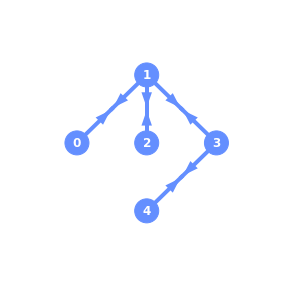

In [3]:
# Set least busy device as backend.
from qiskit.providers.ibmq import least_busy
from qiskit.visualization import plot_gate_map, plot_circuit_layout

small_devices = provider.backends(filters=lambda x: x.configuration().n_qubits == 5
                                   and not x.configuration().simulator)
backend = least_busy(small_devices)

# Set qasm as simulator.
simulator = Aer.get_backend('qasm_simulator')

# Print name and configuration of backend.
from qiskit.visualization import plot_gate_map
print(backend)
plot_gate_map(backend, plot_directed=True)

## Measuring ZZ

In [4]:
# Experimental parameters.
num_gates = np.arange(0, 150, 5)
gate_time = 0.1
qubits = [0]
spectators = [1]

In [5]:
# Circuits to measure ZZ.
from qiskit.ignis.characterization.hamiltonian import ZZFitter, zz_circuits
circs, xdata, osc_freq = zz_circuits(num_gates, gate_time, qubits, spectators, nosc=2)
print(circs[0])

          ░ ┌───┐ ░ ┌───────┐┌───┐ ░ ┌─┐
q0_0: |0>─░─┤ H ├─░─┤ U1(0) ├┤ H ├─░─┤M├
          ░ └───┘ ░ └───────┘└───┘ ░ └╥┘
q0_1: |0>─░────────────────────────░──╫─
          ░                        ░  ║ 
 c0_0: 0 ═════════════════════════════╩═
                                        


In [6]:
# Run circuits on backend.
job = execute(circs, backend, shots=5000)
result = job.result()

ZZ Rate: 28.786977 kHz


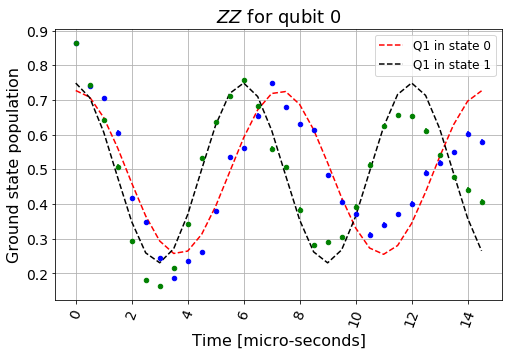

In [7]:
# Fit parameters.
init_a = 1
init_c = 0
init_f = osc_freq
init_phi = -np.pi/20

# Fit to data.
fit_zz = ZZFitter(result, xdata, qubits, spectators,
                  fit_p0 = [init_a, init_f, init_f, init_c],
                  fit_bounds=([-0.5, 0, -np.pi, -0.5],
                               [1.5, 2*osc_freq, np.pi, 1.5]))

# Plot fit.
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
print("ZZ Rate: %f kHz"%(fit_zz.ZZ_rate()[0]*1e3))
fit_zz.plot_ZZ(0, ax = ax);